In [1]:
import os
#os.chdir("/datasets/CIFAR-10")

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
trainset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10',
                                        train=True,
                                        download=False)

trainloader = torch.utils.data.DataLoader(trainset, num_workers=2)

data_orig = trainloader.dataset.train_data
num_data = data_orig.shape[0]
print(data_orig.shape)


(50000, 32, 32, 3)


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root = '/datasets/CIFAR-10',
                                        train = True,
                                       download = True,
                                       transform = transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = '/datasets/CIFAR-10',
                                          train = False,
                                          download = True,
                                          transform = transform)

testloader = torch.utils.data.DataLoader(testset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        num_workers = 2)




Files already downloaded and verified
Files already downloaded and verified


In [4]:
data_orig = testloader.dataset.test_data
num_data = data_orig.shape[0]
print(num_data)
print(len(trainloader))

10000
500


In [5]:
### build net

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as nninit

class CNN_net(nn.Module):
    def __init__(self, front_layer = [(32,),'M',(64,),(64,),(128,),'M'],
                 class_num = 10,
                 back_method = 'FCN',
                 use_BN = True
                 ):
        super(CNN_net, self).__init__()
        
        self.class_num = class_num
        self.back_method = back_method
        self.use_BN = use_BN
        
        self.front_process = self.make_cnn_layers(front_layer,
                                              batch_norm = True)
        if self.back_method == 'FCN':
            if self.use_BN:
                self.back_process = nn.Sequential(
                                    nn.Linear(8*8*front_layer[-2][0], 3000),
                                    nn.BatchNorm1d(3000),
                                    nn.ReLU(),
                                    nn.Linear(3000,400),
                                    nn.BatchNorm1d(400),
                                    nn.ReLU(),
                                    nn.Linear(400,10))
            else:
                self.back_process = nn.Sequential(
                                    nn.Linear(8*8*front_layer[-2][0], 3000),
                                    nn.ReLU(),
                                    nn.Linear(3000,400),
                                    nn.ReLU(),
                                    nn.Linear(400,10))
            
        else:
            raise Exception('Wrong back layer methods')
    
    def forward(self, x):
        x = self.front_process(x)
        x = x.view(x.shape[0], -1)
        x = self.back_process(x)
        return x
        
    def _initialize_weights(self):
        for m in self.modules():
            nninit.xavier_normal_(m.weight, gain = 1)
            nninit.constant_(m.bias, 0)

    def make_cnn_layers(self, cfg, batch_norm=True):

        '''
        The input should be a list, the elements should be tuples. 
        based on pytorch docs:
        Parameters:
            in_channels (int) – Number of channels in the input image
            out_channels (int) – Number of channels produced by the convolution
            kernel_size (int or tuple) – Size of the convolving kernel
            stride (int or tuple, optional) – Stride of the convolution. Default: 1
            padding (int or tuple, optional) – Zero-padding added to both sides of the input. Default: 1
            dilation (int or tuple, optional) – Spacing between kernel elements. Default: 1
            groups (int, optional) – Number of blocked connections from input channels to output channels. Default: 1
            bias (bool, optional) – If True, adds a learnable bias to the output. Default: True

        For convolution layers, the order is:
        (out_channels (int), kernel_size (int or tuple, optional, default = 3), 
        stride (int or tuple, optional), padding (int or tuple, optional), dilation (int or tuple, optional))
        if input is less than 0 (ie. -1) then will use default value.

        For maxpooling layer:
        'M', if need more argument, modify as needed.

        5/3/2018 C.

        '''
        layers = []
        in_channels = 3
        for v in cfg:

            if v[0] == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]

            elif v[0] == 'I':
                in_channels = v[1]

            else:
                v_len = len(v)
                ker_size = 3
                stride_val = 1
                padding_val = 1
                dialtion_val = 1

                out_channels = v[0]
                if v_len >= 2:
                    if v[1] > 0:
                        ker_size = v[1]
                    if v_len >= 3:
                        if v[2] > 0:
                            stride_val = v[2]
                        if v_len >= 4:
                            if v[3] > 0:
                                padding_val = v[3]
                            if v_len >= 5:
                                if v[4] > 0:
                                    dialtion_val = v[4]


                conv2d = nn.Conv2d(in_channels, out_channels, kernel_size = ker_size, stride = stride_val,
                                   padding = padding_val, dilation = dialtion_val)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v[0]), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v[0]
        return nn.Sequential(*layers)


In [6]:
def cal_accu(dataloader):
    total = 0
    correct = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device),labels.to(device)
        outputs = net0(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return 100 * correct / total
    
    

In [7]:
### loss function may calculate wrong in this cell
### May need to modify.

from tqdm import tqdm_notebook as tqdm
import torch.optim as optim

optim_model = 'RMSprop' # 'SGD' ; 'Adagrad' ; 'RMSprop'
use_Nest = False
momentum_val = 0.9
back_method = 'FCN'
use_BN = True
learn_rate = 0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device is ',device)
'''
For convolution layers, the order is:
        (out_channels (int), kernel_size (int or tuple, optional, default = 3), 
        stride (int or tuple, optional), padding (int or tuple, optional), dilation (int or tuple, optional))
        if input is less than 0 (ie. -1) then will use default value.

        For maxpooling layer:
        'M', if need more argument, modify as needed.

'''
CNN_cfg = [[(32,),'M',(64,),(64,),(128,),'M'],
           [(32,),'M',(64,),(64,),(128,),(128,),'M'],
           [(64,),'M',(128,),(128,5,-1,2),(256,),'M']]


net0 = CNN_net(CNN_cfg[2],
             class_num = 10,
             back_method = back_method,
             use_BN = use_BN)

net0.to(device)

criterion = nn.CrossEntropyLoss()

if optim_model == "SGD":
    optimizer = optim.SGD(net0.parameters(), lr = learn_rate, momentum = momentum_val, nesterov= use_Nest)
    model_type = optim_model + '_Nest=' + str(use_Nest) + '_Momentum=' + str(momentum_val) + '_back_layers='\
        + back_method + '_BN=' + str(use_BN)
        
elif optim_model == 'Adagrad':
    optimizer = optim.Adagrad(net0.parameters(), lr = learn_rate)
    model_type = optim_model + '_back_layers='\
        + back_method + '_BN=' + str(use_BN)
    
elif optim_model == 'RMSprop':
    optimizer = optim.RMSprop(net0.parameters(), lr = learn_rate, momentum = momentum_val)
    model_type = optim_model + '_Momentum=' + str(momentum_val) + '_back_layers='\
        + back_method + '_BN=' + str(use_BN)
    
else:
    raise Exception('Wrong optimizer')


epoch_m = 20

loss_train = []
loss_train_mini = []
loss_test = []

accu_train = []
accu_test = []

print('Trianing model with ' + model_type)
print(net0)

for epoch in tqdm(range(1, epoch_m + 1)):
    print('Epoch is ', epoch)
    for i, data in enumerate(trainloader,0):
        inputs, labels = data
        inputs, labels = inputs.to(device),labels.to(device)
        
        optimizer.zero_grad()
        outputs = net0(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    loss_train.append(loss.item() / batch_size)
    accu_train.append(cal_accu(trainloader))
    
    print('training loss', loss_train[-1])
    print('training accuracy', accu_train[-1])
    
    for j, data in enumerate(testloader):
        inputs, labels = data
        inputs, labels = inputs.to(device),labels.to(device)
        
        outputs = net0(inputs)
        loss += criterion(outputs, labels).item()
        
    loss_test.append(loss.item() / (batch_size * len(testloader)))
    accu_test.append(cal_accu(testloader))
    
    print('test loss', loss_test[-1])
    print('test accuracy', accu_test[-1])
        
print('finished')
    
    

device is  cuda:0
Trianing model with RMSprop_Momentum=0.9_back_layers=FCN_BN=True
CNN_net(
  (front_process): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, 

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

Epoch is  1
training loss 0.009616810083389282
training accuracy 65.534
test loss 0.01026190643310547
test accuracy 63.67
Epoch is  2
training loss 0.0073822736740112305
training accuracy 76.51
test loss 0.007946388244628906
test accuracy 73.0
Epoch is  3
training loss 0.007068895697593689
training accuracy 83.12
test loss 0.007131968688964843
test accuracy 75.88
Epoch is  4
training loss 0.005177819728851318
training accuracy 89.452
test loss 0.006749267578125
test accuracy 77.93
Epoch is  5
training loss 0.0036535370349884033
training accuracy 94.902
test loss 0.006683156585693359
test accuracy 79.61
Epoch is  6
training loss 0.0019570209085941316
training accuracy 97.02
test loss 0.0077884521484375
test accuracy 79.87
Epoch is  7
training loss 0.001307765543460846
training accuracy 97.012
test loss 0.008899720001220704
test accuracy 78.72
Epoch is  8
training loss 0.0007950050383806229
training accuracy 97.008
test loss 0.009747077941894531
test accuracy 78.4
Epoch is  9
training lo

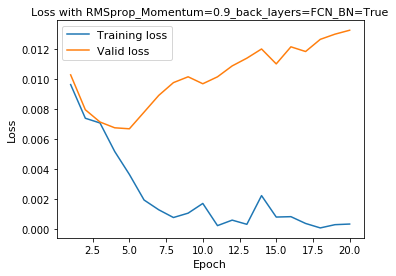

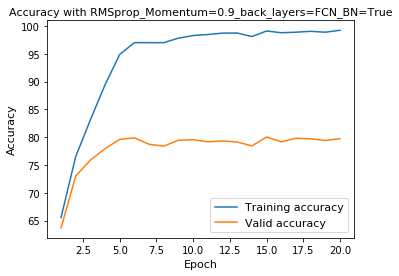

In [9]:
import matplotlib.pyplot as plt


title_accu = 'Accuracy with ' + model_type
title_loss = 'Loss with ' + model_type
        

plt.figure(figsize=(5.5,4))
plt.clf()
plt.plot(list(range(1, len(loss_train) + 1)),loss_train)
plt.plot(list(range(1, len(loss_train) + 1)),loss_test)
plt.xlabel('Epoch',fontsize= 11)
plt.ylabel('Loss',fontsize= 11)
plt.title(title_loss,fontsize= 11)
plt.legend(['Training loss','Valid loss'],fontsize= 11)

plt.show()

plt.figure(figsize=(5.5,4))
plt.clf()
plt.plot(list(range(1, len(accu_train) + 1)),accu_train)
plt.plot(list(range(1, len(accu_train) + 1)),accu_test)
plt.xlabel('Epoch',fontsize= 11)
plt.ylabel('Accuracy',fontsize= 11)
plt.title(title_accu,fontsize= 11)
plt.legend(['Training accuracy','Valid accuracy'],fontsize= 11)
plt.show()